## OOD Evaluation Utilities — Documentation

- This notebook provides utilities for evaluating Out-of-Distribution (OOD) detection
performance using common metrics such as AUROC and AUPR.
- The evaluation is based on
confidence scores assigned by a model to in-distribution (ID) and out-of-distribution
(OOD) samples.
- Lower scores indicate higher likelihood of being OOD.


## Imports

In [9]:
from __future__ import annotations
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve
from probly.evaluation.ood import evaluate_ood
from probly.evaluation.ood_metrics import evaluate_ood_performance


### OodEvaluationResult

A dataclass that stores all metrics and diagnostic arrays generated during OOD evaluation.

**Fields**

- **auroc (float)**  
  Area Under the ROC Curve. Measures how well ID and OOD samples are separable.

- **fpr (np.ndarray)**  
  False Positive Rates for different classification thresholds.

- **tpr (np.ndarray)**  
  True Positive Rates for the same thresholds.

- **labels (np.ndarray)**  
  Ground-truth labels used for evaluation:  
  0 = ID sample, 1 = OOD sample.

- **preds (np.ndarray)**  
  Anomaly scores computed as 1 - confidence.  
  Higher values correspond to higher OOD likelihood.

- **aupr (float)**  
  Area Under the Precision–Recall Curve.

- **precision (np.ndarray)**  
  Precision values for different thresholds.

- **recall (np.ndarray)**  
  Recall values for the same thresholds.

The unified API supports metrics of the form **metric@threshold**, e.g.:

- **fpr@95%**: False positive rate at 95% TPR
- **fnr@90%**: False negative rate at 90% TPR
- **tnr@0.99**: True negative rate at 99% TPR





### evaluate_ood_performance(id_scores, ood_scores)

Computes OOD detection metrics given confidence scores for ID and OOD samples.

#### Parameters
- **id_scores (np.ndarray)**  
  Confidence scores for in-distribution samples. Expected in [0, 1].

- **ood_scores (np.ndarray)**  
  Confidence scores for out-of-distribution samples. Expected in [0, 1].

#### Core Logic
The function assumes the convention:

**Low confidence → more likely OOD**

To transform scores into anomaly predictions, it computes:  
preds = 1.0 - score.

This ensures that **higher values indicate higher OOD likelihood**, which is required
by metrics such as ROC and PR curves.

#### Steps Performed

1. **Clip scores** to [0, 1] to ensure numerical stability:
  - id_scores = np.clip(id_scores, 0.0, 1.0)

2. **Create Labels** 
- 0 for ID samples
- 1 for OOD samples

In [10]:
id_scores = np.array([0.9, 0.8, 0.85])
ood_scores = np.array([0.1, 0.2, 0.05])

labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
labels

array([0., 0., 0., 1., 1., 1.])

3. **Combine Scores**

In [11]:
all_scores = np.concatenate([id_scores, ood_scores])

4. **Convert scores → anomaly predictions:**

In [12]:
preds = 1.0 - all_scores

5. **Compute ROC curve:**

In [13]:
fpr, tpr, _ = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)

6. **Compute Precision–Recall curve & AUPR:**

In [14]:
precision, recall, _ = precision_recall_curve(labels, preds)
aupr = average_precision_score(labels, preds)

7. **Return all metrics inside an OodEvaluationResult.**


After computing AUROC, AUPR, the ROC curve, and the precision–recall curve, the function
packages all results into an `OodEvaluationResult` dataclass, which stores:

- `auroc`: Area under the ROC curve  
- `fpr`: False positive rates  
- `tpr`: True positive rates  
- `labels`: Ground-truth labels (0 = ID, 1 = OOD)  
- `preds`: Anomaly scores (`1 - confidence`)  
- `precision`: Precision values  
- `recall`: Recall values  
- `aupr`: Area under the precision–recall curve  

This structured return object makes it easy to access or visualize each metric.

## Running OOD evaluation

In [15]:
result = evaluate_ood_performance(
    id_scores=id_scores,
    ood_scores=ood_scores,
)


## Visualizing the ROC curve

The ROC curve illustrates the trade-off between the true positive rate (TPR)
and the false positive rate (FPR) across different thresholds.

It is constructed using the `fpr` and `tpr` arrays returned by
`evaluate_ood_performance`.


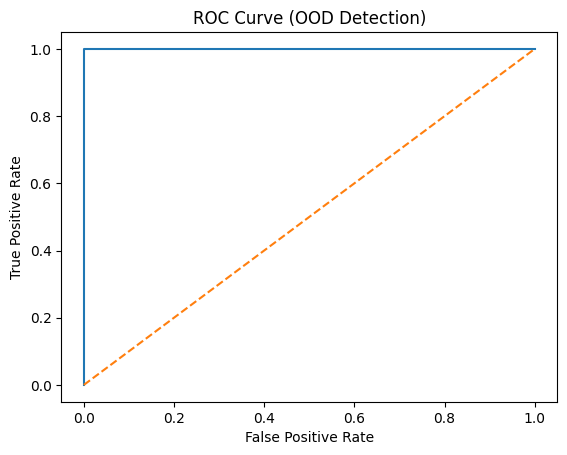

In [16]:

plt.plot(result.fpr, result.tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOD Detection)")
plt.show()


## Visualizing the Precision–Recall curve

The Precision–Recall curve focuses on the performance of OOD detection
when treating OOD samples as the positive class.

This visualization is especially informative when OOD samples are rare.


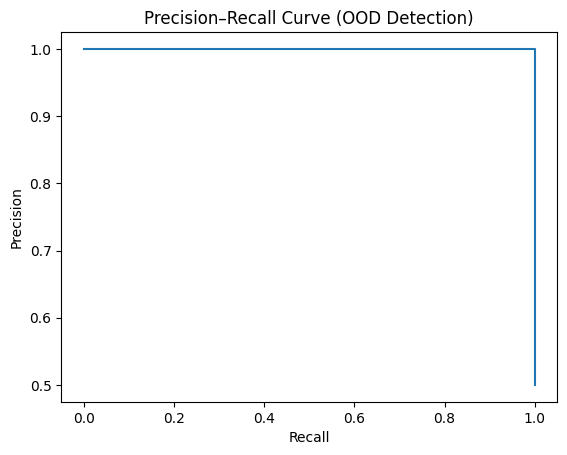

In [17]:
plt.plot(result.recall, result.precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOD Detection)")
plt.show()


## Visualizing OOD score distributions

To gain an intuitive understanding of OOD behavior, we visualize the
distribution of anomaly scores for in-distribution and out-of-distribution
samples.

The anomaly score is defined as `1 - confidence`, where higher values
indicate a higher likelihood of being OOD.


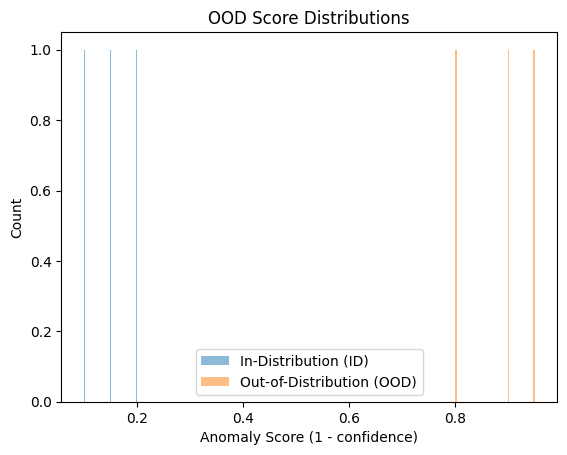

In [18]:
id_preds = result.preds[result.labels == 0]
ood_preds = result.preds[result.labels == 1]

plt.hist(id_preds, bins=50, alpha=0.5, label="In-Distribution (ID)")
plt.hist(ood_preds, bins=50, alpha=0.5, label="Out-of-Distribution (OOD)")
plt.xlabel("Anomaly Score (1 - confidence)")
plt.ylabel("Count")
plt.legend()
plt.title("OOD Score Distributions")
plt.show()


In summary, `evaluate_ood_performance` enables detailed analysis and
visualization of OOD behavior, while `evaluate_ood` provides a clean
and flexible interface for metric-based evaluation.
